In [ ]:
# scrollTo=ANlFS0LRB-Sz
#https: // colab.research.google.com/github/varun19299/wireless-lab-iitm/blob/notebooks/4-ofdm-python.ipynb
# https://github.com/veeresht/CommPy
!pip install scikit-commpy


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import commpy as cpy

# 1 初始化参数

In [2]:
K = 64 # OFDM子载波数量
CP = K//4  #25%的循环前缀长度
P = 8  # 导频数
pilotValue = 3+3j  # 导频格式
Modulation_type = 'QAM16' #调制方式，可选BPSK、QPSK、8PSK、QAM16、QAM64
channel_type ='random' # 信道类型，可选awgn
SNRdb = 25  # 接收端的信噪比（dB）
allCarriers = np.arange(K)  # 子载波编号 ([0, 1, ... K-1])
pilotCarrier = allCarriers[::K//P]  # 每间隔P个子载波一个导频
# 为了方便信道估计，将最后一个子载波也作为导频
pilotCarriers = np.hstack([pilotCarrier, np.array([allCarriers[-1]])])
P = P+1 # 导频的数量也需要加1


# 2 可视化导频插入的方式

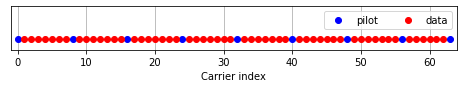

In [3]:
# 可视化数据和导频的插入方式
dataCarriers = np.delete(allCarriers, pilotCarriers)
plt.figure(figsize=(8, 0.8))
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.legend(fontsize=10, ncol=2)
plt.xlim((-1, K))
plt.ylim((-0.1, 0.3))
plt.xlabel('Carrier index')
plt.yticks([])
plt.grid(True)
plt.savefig('carrier.png')

# 3 定义调制和解调方式

In [4]:
m_map = {"BPSK": 1, "QPSK": 2, "8PSK": 3, "QAM16": 4, "QAM64": 6}
mu = m_map[Modulation_type]
payloadBits_per_OFDM = len(dataCarriers)*mu  # 每个 OFDM 符号的有效载荷位数
# 定制调制方式
def Modulation(bits):
    if Modulation_type == "QPSK":
        PSK8 = cpy.PSKModem(4)
        symbol = PSK4.modulate(bits)
        return symbol
    elif Modulation_type == "QAM64":
        QAM64 = cpy.QAMModem(64)
        symbol = QAM64.modulate(bits)
        return symbol
    elif Modulation_type == "QAM16":
        QAM16 = cpy.QAMModem(16)
        symbol = QAM16.modulate(bits)
        return symbol
    elif Modulation_type == "8PSK":
        PSK8 = cpy.PSKModem(8)
        symbol = PSK8.modulate(bits)
        return symbol
    elif Modulation_type == "BPSK":
        BPSK = cpy.PSKModem(2)
        symbol = BPSK.modulate(bits)
        return symbol
# 定义解调方式
def DeModulation(symbol):
    if Modulation_type == "QPSK":
        PSK8 = cpy.PSKModem(4)
        bits = PSK4.demodulate(symbol, demod_type='hard')
        return bits
    elif Modulation_type == "QAM64":
        QAM64 = cpy.QAMModem(64)
        bits = QAM64.demodulate(symbol, demod_type='hard')
        return bits
    elif Modulation_type == "QAM16":
        QAM16 = cpy.QAMModem(16)
        bits = QAM16.demodulate(symbol, demod_type='hard')
        return bits
    elif Modulation_type == "8PSK":
        PSK8 = cpy.PSKModem(8)
        bits = PSK8.demodulate(symbol, demod_type='hard')
        return bits
    elif Modulation_type == "BPSK":
        BPSK = cpy.PSKModem(2)
        bits = BPSK.demodulate(symbol, demod_type='hard')
        return bits


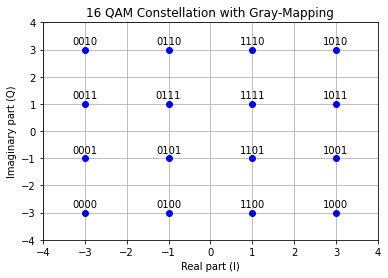

In [5]:
# 举例16QAM调制方式，画出星座图
mapping_table = {
    (0, 0, 0, 0): -3-3j,
    (0, 0, 0, 1): -3-1j,
    (0, 0, 1, 0): -3+3j,
    (0, 0, 1, 1): -3+1j,
    (0, 1, 0, 0): -1-3j,
    (0, 1, 0, 1): -1-1j,
    (0, 1, 1, 0): -1+3j,
    (0, 1, 1, 1): -1+1j,
    (1, 0, 0, 0):  3-3j,
    (1, 0, 0, 1):  3-1j,
    (1, 0, 1, 0):  3+3j,
    (1, 0, 1, 1):  3+1j,
    (1, 1, 0, 0):  1-3j,
    (1, 1, 0, 1):  1-1j,
    (1, 1, 1, 0):  1+3j,
    (1, 1, 1, 1):  1+1j
}
for b3 in [0, 1]:
    for b2 in [0, 1]:
        for b1 in [0, 1]:
            for b0 in [0, 1]:
                B = (b3, b2, b1, b0)
                Q = mapping_table[B]
                plt.plot(Q.real, Q.imag, 'bo')
                plt.text(Q.real, Q.imag+0.2, "".join(str(x)
                         for x in B), ha='center')
plt.grid(True)
plt.xlim((-4, 4))
plt.ylim((-4, 4))
plt.xlabel('Real part (I)')
plt.ylabel('Imaginary part (Q)')
plt.title('16 QAM Constellation with Gray-Mapping')
plt.savefig('constellation.png')

# 4 定义信道

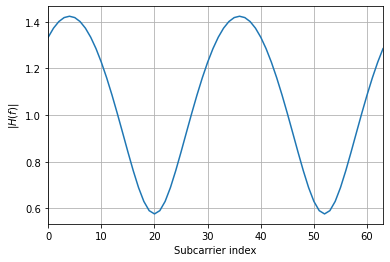

In [22]:
# 可视化信道冲击响应，仿真信道
# the impulse response of the wireless channel
channelResponse = np.array([1, 0, 0.3+0.3j])
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))
plt.xlabel('Subcarrier index')
plt.ylabel('$|H(f)|$')
plt.grid(True)
plt.xlim(0, K-1)
plt.savefig('channelresponse.png')
# 定义信道
def add_awgn(x_s, snrDB):
    data_pwr = np.mean(abs(x_s**2))
    noise_pwr = data_pwr/(10**(snrDB/10))
    noise = 1/np.sqrt(2) * (np.random.randn(len(x_s)) + 1j *
                            np.random.randn(len(x_s))) * np.sqrt(noise_pwr)
    return x_s + noise, noise_pwr
def channel(in_signal, SNRdb, channel_type="awgn"):
    channelResponse = np.array([1, 0, 0.3+0.3j]) #随意仿真信道冲击响应
    if channel_type == "random":
        convolved = np.convolve(in_signal, channelResponse)
        out_signal, noise_pwr = add_awgn(convolved, SNRdb)
    elif channel_type == "awgn":
        out_signal, noise_pwr = add_awgn(in_signal, SNRdb)
    return out_signal, noise_pwr


# 5 OFDM通信仿真

In [7]:
# 5.1 产生比特流
bits = np.random.binomial(n=1, p=0.5, size=(payloadBits_per_OFDM, ))


In [8]:
# 5.2 比特信号调制
QAM_s = Modulation(bits)
print(QAM_s)

[ 3.-3.j -3.+1.j  1.-1.j  1.-3.j -1.+3.j -3.-3.j -3.+3.j -1.+1.j -1.+3.j
 -3.+3.j -1.+3.j  3.-1.j  1.-3.j -3.+3.j -1.-1.j -1.-3.j  1.+3.j -1.-1.j
  1.+3.j  3.+3.j -3.-1.j  3.+1.j -3.-3.j  1.-3.j -1.+3.j  3.+3.j  3.-1.j
 -1.-3.j -1.+3.j -3.-3.j  1.+1.j -1.+1.j -3.-1.j -3.-1.j  3.-3.j  3.-3.j
  1.+1.j -3.-3.j -3.+1.j -3.-3.j -1.+3.j -3.-1.j -3.-1.j -3.-3.j -1.-3.j
  3.+1.j -3.+1.j  3.+1.j -3.-3.j -3.-3.j -1.+3.j  1.-1.j  1.-1.j  1.-3.j
  1.-3.j]


In [9]:
# 5.3 插入导频和数据，生成OFDM符号
def OFDM_symbol(QAM_payload):
    symbol = np.zeros(K, dtype=complex) # 子载波位置
    symbol[pilotCarriers] = pilotValue  # 在导频位置插入导频
    symbol[dataCarriers] = QAM_payload  # 在数据位置插入数据
    return symbol
OFDM_data = OFDM_symbol(QAM_s)


In [10]:
# 5.4 快速傅里叶逆变换
def IDFT(OFDM_data):
    return np.fft.ifft(OFDM_data)
OFDM_time = IDFT(OFDM_data)
OFDM_time


array([-0.03125   +0.15625j   , -0.3923343 +0.17375492j,
        0.25722691-0.35230191j,  0.12994576-0.33306119j,
        0.07990995-0.2075228j ,  0.52750336+0.06635579j,
        0.19079772-0.02504329j, -0.33716026+0.30927508j,
        0.45044417+0.07544417j, -0.1363671 -0.03163124j,
       -0.34843685+0.06147178j,  0.33492425+0.51181338j,
       -0.11598883+0.0442944j ,  0.24998674+0.04091973j,
       -0.01238811-0.34734403j,  0.76842316-0.23352276j,
        0.46875   +0.71875j   ,  0.08070921-0.15473239j,
       -0.04668718+0.17074146j, -0.01427249-0.35782058j,
        0.44309195+0.183867j  ,  0.01408013+0.06499908j,
       -0.26930941+0.06168971j,  0.3965608 -0.2837393j ,
        0.5830267 +0.7705267j ,  0.26575464+0.23888648j,
        0.39575803+0.09503111j, -0.16895219+0.10548866j,
       -0.48046599-0.33326867j, -0.36943439+0.07458374j,
       -0.476137  +0.05885306j, -0.42077529+0.13441704j,
        0.40625   +0.46875j   ,  0.71779368-0.23787718j,
       -0.32681789-0.31489827j,

In [11]:
# 5.5 添加循环前缀
def addCP(OFDM_time):
    cp = OFDM_time[-CP:]               
    return np.hstack([cp, OFDM_time])  
OFDM_withCP = addCP(OFDM_time)
OFDM_withCP


array([ 0.53125   +0.40625j   , -0.03169242-0.2628992j ,
        0.20466652+0.05451698j, -0.06899863+0.18153531j,
       -0.32567447+0.57815726j,  0.09988762+0.24333094j,
        0.01806307-0.37478215j,  0.01287461+0.22833067j,
        0.2294733 +0.4169733j , -0.0540855 +0.07447805j,
        0.32471059+0.54995113j,  0.0664892 -0.33254521j,
        0.00949512+0.01318615j,  0.28044143-0.03520449j,
        0.36691784+0.14455785j,  0.38168135-0.17925699j,
       -0.03125   +0.15625j   , -0.3923343 +0.17375492j,
        0.25722691-0.35230191j,  0.12994576-0.33306119j,
        0.07990995-0.2075228j ,  0.52750336+0.06635579j,
        0.19079772-0.02504329j, -0.33716026+0.30927508j,
        0.45044417+0.07544417j, -0.1363671 -0.03163124j,
       -0.34843685+0.06147178j,  0.33492425+0.51181338j,
       -0.11598883+0.0442944j ,  0.24998674+0.04091973j,
       -0.01238811-0.34734403j,  0.76842316-0.23352276j,
        0.46875   +0.71875j   ,  0.08070921-0.15473239j,
       -0.04668718+0.17074146j,

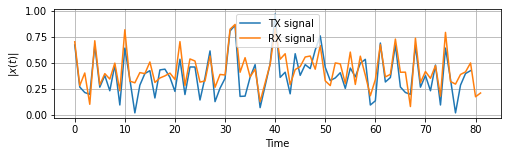

In [12]:
# 5.6 经过信道
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX, SNRdb, "random")[0]
plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel('Time'); plt.ylabel('$|x(t)|$');
plt.grid(True);
# plt.savefig('tran-receiver.png')

Now, at the receiver the CP is removed from the signal and a window of $K$ samples is extracted from the received signal.

In [13]:
# 5.7 接收端，去除循环前缀
def removeCP(signal):
    return signal[CP:(CP+K)]
OFDM_RX_noCP = removeCP(OFDM_RX)

In [14]:
# 5.8 快速傅里叶变换
def DFT(OFDM_RX):
    return np.fft.fft(OFDM_RX)
OFDM_demod = DFT(OFDM_RX_noCP)

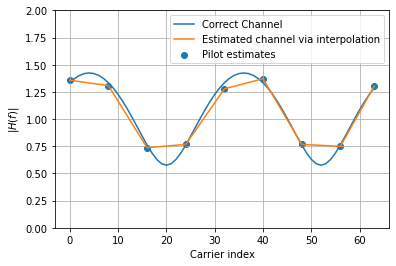

In [15]:
# 5.9 信道估计
def channelEstimate(OFDM_demod):
    pilots = OFDM_demod[pilotCarriers]  # 取导频处的数据
    Hest_at_pilots = pilots / pilotValue  # LS信道估计
    
    # 在导频载波之间进行插值以获得估计，然后利用插值估计得到数据下标处的信道响应
    Hest_abs = interpolate.interp1d(pilotCarriers, abs(Hest_at_pilots), kind='linear')(allCarriers)
    Hest_phase = interpolate.interp1d(pilotCarriers, np.angle(Hest_at_pilots), kind='linear')(allCarriers)
    Hest = Hest_abs * np.exp(1j*Hest_phase)
    
    plt.plot(allCarriers, abs(H_exact), label='Correct Channel')
    plt.scatter(pilotCarriers, abs(Hest_at_pilots), label='Pilot estimates')
    plt.plot(allCarriers, abs(Hest), label='Estimated channel via interpolation')
    plt.grid(True); plt.xlabel('Carrier index'); plt.ylabel('$|H(f)|$'); plt.legend(fontsize=10)
    plt.ylim(0,2)
    plt.savefig('信道响应估计.png')
    return Hest
Hest = channelEstimate(OFDM_demod)


In [21]:
# 5.10 均衡
def equalize(OFDM_demod, Hest):
    return OFDM_demod / Hest
equalized_Hest = equalize(OFDM_demod, Hest)
def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(equalized_Hest)

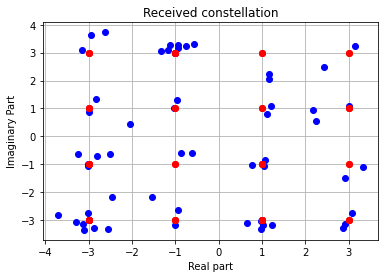

In [18]:
# 5.10 获取数据位置的数据
def get_payload(equalized):
    return equalized[dataCarriers]
QAM_est = get_payload(equalized_Hest)
# 可视化均衡后的星座图
plt.plot(QAM_est.real, QAM_est.imag, 'bo')
plt.plot(QAM_s.real, QAM_s.imag, 'ro')

plt.grid(True)
plt.xlabel('Real part')
plt.ylabel('Imaginary Part')
plt.title("Received constellation")
plt.savefig('map.png')


In [19]:
# 5.11 反映射，解调
bits_est = DeModulation(QAM_est)
bits_est


array([1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0],
      dtype=int8)

# 6 计算误比特率

In [20]:
print ("误比特率BER： ", np.sum(abs(bits-bits_est))/len(bits))

误比特率BER：  0.0
